# Model Grawitacji

In [ ]:
!pip install matplotlib_scalebar --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import geopandas as gpd
from scipy.spatial.distance import cdist
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar

In [ ]:
# Wczytanie danych
migration_file = 'Migracje.csv'
wage_file = 'Wynagrodzenie.csv'

migration_data = pd.read_csv(migration_file, encoding='latin1', sep=';')
wage_data = pd.read_csv(wage_file, encoding='latin1', sep=';')

In [ ]:
# Czyszczenie danych migracyjnych
migration_data = migration_data.iloc[2:].reset_index(drop=True)  # Usunięcie nagłówków
migration_data.columns = ['Nazwa'] + [
    col.encode('latin1', errors='ignore').decode('utf-8', errors='ignore').strip().upper()
    for col in migration_data.columns[1:]
]

migration_data.iloc[:, 1:] = migration_data.iloc[:, 1:].replace(' ', '', regex=True).applymap(
    lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x
)

<ipython-input-3-ec98730cea24>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  migration_data.iloc[:, 1:] = migration_data.iloc[:, 1:].replace(' ', '', regex=True).applymap(


In [ ]:
# Mapowanie błędnych nazw na poprawne
fix_mapping = {
    '£ÓDZKIE': 'ŁÓDZKIE',
    'DOLNO\x8cL¥SKIE': 'DOLNOŚLĄSKIE',
    'MA£OPOLSKIE': 'MAŁOPOLSKIE',
    '\x8cL¥SKIE': 'ŚLĄSKIE',
    'WARMIÑSKO-MAZURSKIE': 'WARMIŃSKO-MAZURSKIE',
    '\x8cWIÊTOKRZYSKIE': 'ŚWIĘTOKRZYSKIE',
    'LSKIE': 'ŚLĄSKIE',
    'DZKIE': 'ŁÓDZKIE',
    'WARMISKO-MAZURSKIE': 'WARMIŃSKO-MAZURSKIE',
    'DOLNOLSKIE': 'DOLNOŚLĄSKIE',
    'WITOKRZYSKIE': 'ŚWIĘTOKRZYSKIE',
    'MAOPOLSKIE': 'MAŁOPOLSKIE'
}

# Normalizacja nazw w migration_data
migration_data['Nazwa'] = migration_data['Nazwa'].replace(fix_mapping)
migration_data.columns = ['Nazwa'] + [
    fix_mapping.get(col, col) for col in migration_data.columns[1:]
]

In [ ]:
# Czyszczenie danych wynagrodzeń
wage_data['Województwo'] = wage_data['Województwo'].str.upper().str.strip()
wage_data['WynagrodzeniePLN'] = wage_data['WynagrodzeniePLN'].replace(' ', '', regex=True).apply(
    lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x
)
wage_data.rename(columns={'WynagrodzeniePLN': 'Wynagrodzenie'}, inplace=True)

# Normalizacja nazw w wage_data
wage_data['Województwo'] = wage_data['Województwo'].replace(fix_mapping)


In [ ]:
# Mapowanie wynagrodzeń
wage_map = wage_data.set_index('Województwo')['Wynagrodzenie'].to_dict()

# Wczytanie shapefile województw
wojewodztwa = gpd.read_file('wojewodztwa.shp', encoding='latin1')

# Poprawienie kodowania nazw województw w pliku shapefile
wojewodztwa['wojewodztwo'] = wojewodztwa['JPT_NAZWA_'].str.encode('latin1', errors='ignore').str.decode('utf-8', errors='ignore').str.upper()

# Mapowanie błędnych nazw w danych geograficznych
wojewodztwa['wojewodztwo'] = wojewodztwa['wojewodztwo'].replace(fix_mapping)


# Obliczenie centroidów województw
wojewodztwa['centroid'] = wojewodztwa.geometry.centroid
wojewodztwa['centroid_x'] = wojewodztwa['centroid'].x
wojewodztwa['centroid_y'] = wojewodztwa['centroid'].y

# Przygotowanie DataFrame z koordynatami centroidów
centroids = wojewodztwa[['wojewodztwo', 'centroid_x', 'centroid_y']]
centroids = centroids.set_index('wojewodztwo')

In [ ]:
# Sprawdzenie poprawności po mapowaniu
print("Unikalne województwa w danych migracyjnych:", set(migration_data['Nazwa']))
print("Unikalne województwa w danych geograficznych:", set(wojewodztwa['wojewodztwo']))
print("Unikalne województwa w danych wynagrodzeń:", set(wage_data['Województwo']))

Unikalne województwa w danych migracyjnych: {'MAŁOPOLSKIE', 'OPOLSKIE', 'LUBUSKIE', 'POMORSKIE', 'LUBELSKIE', 'WIELKOPOLSKIE', 'KUJAWSKO-POMORSKIE', 'PODKARPACKIE', 'MAZOWIECKIE', 'PODLASKIE', 'ŚWIĘTOKRZYSKIE', 'ŁÓDZKIE', 'WARMIŃSKO-MAZURSKIE', 'ZACHODNIOPOMORSKIE', 'DOLNOŚLĄSKIE', 'ŚLĄSKIE'}
Unikalne województwa w danych geograficznych: {'OPOLSKIE', 'MAŁOPOLSKIE', 'LUBUSKIE', 'POMORSKIE', 'WIELKOPOLSKIE', 'LUBELSKIE', 'KUJAWSKO-POMORSKIE', 'PODKARPACKIE', 'MAZOWIECKIE', 'ŚWIĘTOKRZYSKIE', 'PODLASKIE', 'ZACHODNIOPOMORSKIE', 'ŁÓDZKIE', 'WARMIŃSKO-MAZURSKIE', 'DOLNOŚLĄSKIE', 'ŚLĄSKIE'}
Unikalne województwa w danych wynagrodzeń: {'MAŁOPOLSKIE', 'OPOLSKIE', 'LUBUSKIE', 'POMORSKIE', 'LUBELSKIE', 'WIELKOPOLSKIE', 'KUJAWSKO-POMORSKIE', 'PODKARPACKIE', 'MAZOWIECKIE', 'PODLASKIE', 'ŚWIĘTOKRZYSKIE', 'ŁÓDZKIE', 'WARMIŃSKO-MAZURSKIE', 'ZACHODNIOPOMORSKIE', 'DOLNOŚLĄSKIE', 'ŚLĄSKIE'}


In [ ]:
# Obliczenie macierzy odległości na podstawie centroidów
distance_matrix = pd.DataFrame(
    cdist(centroids.values, centroids.values, metric='euclidean'),
    index=centroids.index,
    columns=centroids.index
)

# Zamiana macierzy na wektor (zgodność z dotychczasowym formatem projektu)
distance_vector = distance_matrix.values.flatten()


In [ ]:
# Przygotowanie danych
migration_matrix = migration_data.iloc[:, 1:].values
origins = np.repeat(migration_data['Nazwa'].values, len(migration_data.columns) - 1)
destinations = np.tile(migration_data.columns[1:], len(migration_data))

origin_wages = [wage_map.get(origin, np.nan) for origin in origins]
destination_wages = [wage_map.get(destination, np.nan) for destination in destinations]

In [ ]:
# Przygotowanie końcowego DataFrame
data = pd.DataFrame({
    'Migration': migration_matrix.flatten(),
    'Origin_Wage': origin_wages,
    'Destination_Wage': destination_wages,
    'Distance': distance_vector[:migration_matrix.size]
})

data = data.dropna()
data['Migration'] = data['Migration'].astype(float)
data = data[data['Migration'] > 0]

In [ ]:
# Logarytmizacja
data['Log_Migration'] = np.log(data['Migration'])
data['Log_Origin_Wage'] = np.log(data['Origin_Wage'])
data['Log_Destination_Wage'] = np.log(data['Destination_Wage'])
data['Log_Distance'] = np.log(data['Distance'])

In [ ]:
# Estymacja modelu
X = data[['Log_Origin_Wage', 'Log_Destination_Wage', 'Log_Distance']]
y = data['Log_Migration']
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
r2 = r2_score(y, predictions)

In [ ]:
coefficients = pd.DataFrame({
    'Variable': ['Log_Origin_Wage', 'Log_Destination_Wage', 'Log_Distance'],
    'Coefficient': model.coef_
})
coefficients['Intercept'] = model.intercept_
print(coefficients)
print("R-squared:", r2)


               Variable  Coefficient   Intercept
0       Log_Origin_Wage     4.676921 -107.429298
1  Log_Destination_Wage     8.067708 -107.429298
2          Log_Distance     0.272760 -107.429298
R-squared: 0.3818663741885062


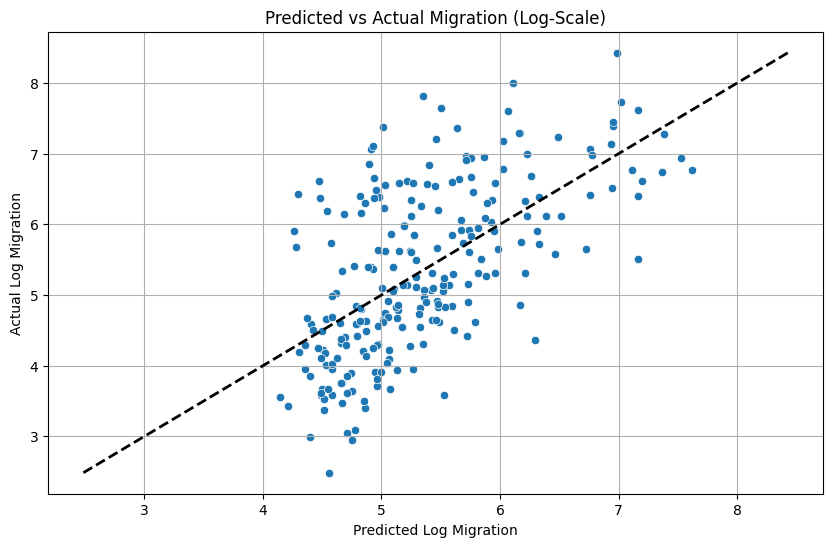

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=y, edgecolor='w')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Predicted Log Migration')
plt.ylabel('Actual Log Migration')
plt.title('Predicted vs Actual Migration (Log-Scale)')
plt.grid(True)
plt.show()


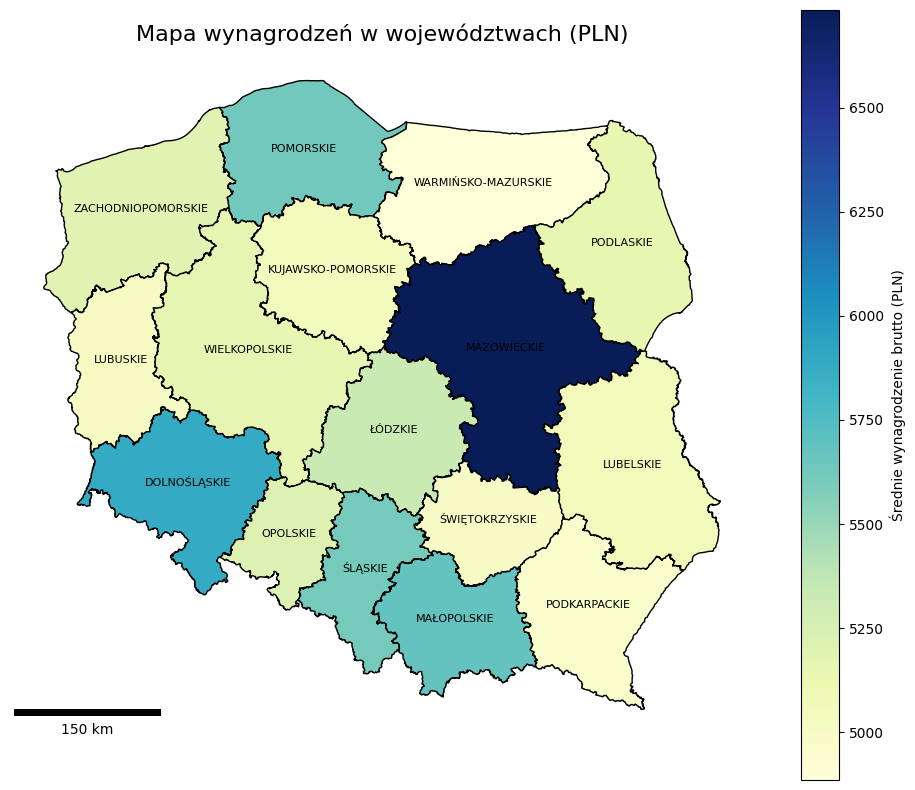

In [ ]:
# Połączenie danych wynagrodzeń z geometrią województw
wojewodztwa = wojewodztwa.merge(wage_data, left_on='wojewodztwo', right_on='Województwo')

# Tworzenie mapy wynagrodzeń
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Rysowanie mapy z wynagrodzeniami
wojewodztwa.plot(
    column='Wynagrodzenie',
    cmap='YlGnBu',
    legend=True,
    legend_kwds={'label': "Średnie wynagrodzenie brutto (PLN)"},
    edgecolor='black',
    ax=ax
)

# Dodanie nazw województw
for idx, row in wojewodztwa.iterrows():
    plt.text(
        row['centroid'].x,
        row['centroid'].y,
        row['wojewodztwo'],
        fontsize=8,
        ha='center',
        color='black'
    )

# Dodanie skali
scalebar = ScaleBar(1, units="m", dimension="si-length", location="lower left", scale_loc="bottom")
ax.add_artist(scalebar)

# Ustawienia osi
ax.set_title("Mapa wynagrodzeń w województwach (PLN)", fontsize=16)
ax.set_axis_off()

plt.show()